In [1]:
reset -sf

In [2]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D, Input, add
from keras import layers
from keras.models import Model

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 
import matplotlib.pyplot as plt

/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/importlib/_bo

In [3]:
PATH = Path("../../data/")

In [4]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [5]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [6]:
trainY_n = dfY_Train[:,ini:ini+dim]
valY_n = dfY_Val[:,ini:ini+dim]
testY_n = dfY_Test[:,ini:ini+dim]

In [7]:
trainX_0_n = dfX_Train [:,ini:ini+dim]
trainX_1_n = dfX_Train [:,ini+ecg:ini+ecg+dim]

valX_0_n =dfX_Val [:,ini:ini+dim]
valX_1_n = dfX_Val[:,ecg+ini:ini+ecg+dim]

testX_0_n = dfX_Test[:,ini:ini+dim]
testX_1_n = dfX_Test[:,ecg+ini:ini+ecg+dim]

trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

4.5 -3.498 0.8156937694160916
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [9]:
# Standardize

(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [8]:
scaler_ppg = StandardScaler().fit(trainX_n[:,:,0])
scaler_ecg = StandardScaler().fit(trainX_n[:,:,1])
print(scaler_ppg.mean_.shape)
print(scaler_ecg.mean_.shape)

(250,)
(250,)


In [9]:
trainX_n = np.stack((scaler_ppg.transform(trainX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(trainX_n[:,:,1]).reshape(-1,dim)), axis=2)
valX_n = np.stack((scaler_ppg.transform(valX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(valX_n[:,:,1]).reshape(-1,dim)), axis=2)
testX_n = np.stack((scaler_ppg.transform(testX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(testX_n[:,:,1]).reshape(-1,dim)), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

12.232114683629453 -11.461019164899536 1.0000000000000004
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [10]:
#Definition of the model

In [80]:
input_tensor = Input(shape=(dim, 2))

x = Conv1D(filters=64, kernel_size=7, activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=128, kernel_size=7, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=256, kernel_size=7, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=512, kernel_size=7, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

#x = GlobalMaxPooling1D()(x)

x = Flatten()(x)
x = Dense(5120, activation='relu')(x) #5120
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(5120//2, activation='relu')(x) #5120
x = Dropout(0.5)(x)

#Very important!!!
x = BatchNormalization()(x)
x = Dense(dim)(x)

model = Model(input_tensor,x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 250, 2)            0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 244, 64)           960       
_________________________________________________________________
batch_normalization_101 (Bat (None, 244, 64)           256       
_________________________________________________________________
max_pooling1d_75 (MaxPooling (None, 122, 64)           0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 122, 64)           0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 116, 128)          57472     
_________________________________________________________________
batch_normalization_102 (Bat (None, 116, 128)          512       
__________

In [70]:
# fit model
model.compile(optimizer=optimizers.Adam(lr=1e-3), loss='mae')
history_prev = history
history = model.fit(trainX_n, trainY_n, validation_data=(valX_n, valY_n), batch_size=64, epochs=20, verbose=1)

Train on 8126 samples, validate on 1016 samples
Epoch 1/20
8126/8126 [==============================] - 16s 2ms/step - loss: 65.2080 - val_loss: 237.6558
Epoch 2/20
8126/8126 [==============================] - 10s 1ms/step - loss: 18.9557 - val_loss: 20.0640
Epoch 3/20
8126/8126 [==============================] - 10s 1ms/step - loss: 18.0397 - val_loss: 19.7156
Epoch 4/20
8126/8126 [==============================] - 10s 1ms/step - loss: 17.4503 - val_loss: 18.4147
Epoch 5/20
8126/8126 [==============================] - 10s 1ms/step - loss: 16.7386 - val_loss: 17.6634
Epoch 6/20
8126/8126 [==============================] - 10s 1ms/step - loss: 16.2372 - val_loss: 17.8731
Epoch 7/20
8126/8126 [==============================] - 10s 1ms/step - loss: 15.8278 - val_loss: 17.0498
Epoch 8/20
8126/8126 [==============================] - 10s 1ms/step - loss: 15.2086 - val_loss: 16.5463
Epoch 9/20
8126/8126 [==============================] - 10s 1ms/step - loss: 14.8500 - val_loss: 16.4970
Epoch 

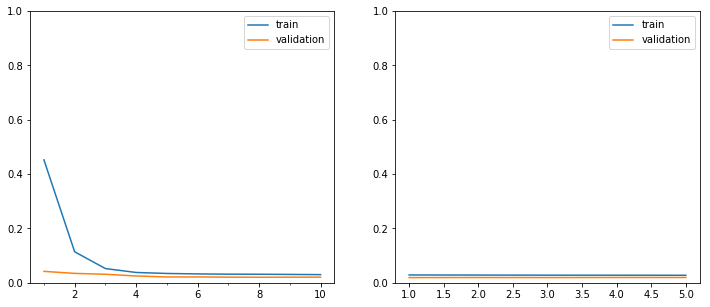

In [14]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    ax.set_ylim(0.0,1.0)
    ax.legend()

plt.show()

In [ ]:
# Save the weights and architecture

In [15]:
model.save_weights('conv1d.h5')
with open('conv1d.json', 'w') as f:
    f.write(model.to_json())

In [11]:
model.load_weights('conv1d.h5')

In [ ]:
#Evaluation

In [20]:
y_pred = []
for ix in range(testX_n.shape[0]):
    y_pred.append(model.predict([np.expand_dims(testX_n[ix,:].reshape(250,2),0)]))

In [21]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

y_pred = np.array(y_pred).reshape(-1,250)
print(y_pred.shape, testY_n.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_n, y_pred))
print("MAE error:", mean_absolute_error(testY_n, y_pred))
print("MSE error:", mean_squared_error(testY_n, y_pred))
print("R2 score:", r2_score(testY_n, y_pred))

(1016, 250) (1016, 250)
Test error analysis:
Explained variance score: 0.4279777677055694
MAE error: 14.160771845684142
MSE error: 371.1440771845821
R2 score: 0.4099544487852887


In [54]:
# Visualize

(1, 250, 2)


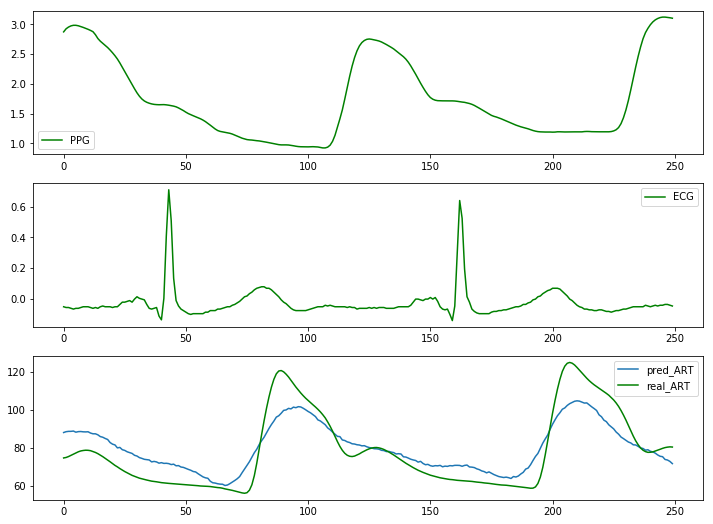

In [23]:
ix=12

print(np.expand_dims(testX_n[ix,:], axis=0).shape)

plt.figure(figsize=(12,9))
ax = plt.subplot(3,1,1)
ax.plot(testX_0_n[ix,:].reshape(1,-1).T, c="g", label="PPG")
ax.legend()

ax = plt.subplot(3,1,2)
ax.plot(testX_1_n[ix,:].reshape(1,-1).T, c="g", label="ECG")
plt.legend()


ax = plt.subplot(3,1,3)
ax.plot(model.predict(np.expand_dims(testX_n[ix,:], axis=0)).T, label="pred_ART")
ax.plot(testY_n[ix,:].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()

plt.show()